Importazione delle Librerie

In [26]:
import torch.nn as nn
import torch.optim as optim
import glob
from torch.utils.data import DataLoader
from torchvision import transforms, models
from torch.cuda.amp import GradScaler, autocast
import os
import csv
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
import torch
import pandas as pd
import matplotlib.pyplot as plt

Definizione della Classe CustomDataset

In [27]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted([d for d in os.listdir(self.root_dir) if os.path.isdir(os.path.join(self.root_dir, d))])
        self.data = []
        self.targets = []

        for idx, cls in enumerate(self.classes):
            class_dir = os.path.join(self.root_dir, cls)
            for file in os.listdir(class_dir):
                file_path = os.path.join(class_dir, file)
                if os.path.isfile(file_path):
                    self.data.append(file_path)
                    self.targets.append(idx)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]
        image = Image.open(img_path).convert('RGB')
        target = self.targets[idx]

        if self.transform:
            image = self.transform(image)

        return image, target

Funzioni per il Caricamento e il Salvataggio dei Checkpoint

In [28]:
def load_checkpoint(checkpoint_path, model, optimizer):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    start_epoch += 1
    metrics = checkpoint['metrics']
    return model, optimizer, start_epoch, metrics

def save_checkpoint(checkpoint_state, checkpoint_path):
    torch.save(checkpoint_state, checkpoint_path)

Funzione per il Calcolo delle Metriche

In [29]:
def calculate_metrics(loader, model, device):
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Calcolo metriche"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds)

    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=1)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=1)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=1)

    return accuracy, precision, recall, f1

Preparazione dei Dati

In [30]:
from Dataset import CustomDataset

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_dataset_path = r'C:\Users\biagi\PycharmProjects\gruppo17\Bilanciamento_Allenamento_Target'
val_dataset_path = r'C:\Users\biagi\PycharmProjects\gruppo17\Validazione_Target'

train_dataset = CustomDataset(train_dataset_path, transform=transform)
val_dataset = CustomDataset(val_dataset_path, transform=transform)

print(f"Classi trovate nel dataset di addestramento: {train_dataset.classes}")
print(f"Classi trovate nel dataset di validazione: {val_dataset.classes}")

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True)

Classi trovate nel dataset di addestramento: ['Cargo', 'Echosounder', 'Passengership', 'Seal bomb', 'Seismic airguns surveys', 'Sonar', 'Tanker', 'Tug', 'Vessel']
Classi trovate nel dataset di validazione: ['Cargo', 'Echosounder', 'Passengership', 'Seal bomb', 'Seismic airguns surveys', 'Sonar', 'Tanker', 'Tug', 'Vessel']


Inizializzazione del Modello

In [31]:
num_classes = len(train_dataset.classes)
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, num_classes)

for param in model.parameters():
    param.requires_grad = False

for param in model.fc.parameters():
    param.requires_grad = True

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

torch.backends.cudnn.benchmark = True

scaler = GradScaler()

Caricamento del Checkpoint

In [32]:
checkpoint_dir = r'C:\Users\biagi\PycharmProjects\gruppo17\Esperimento 4 Multiclasse\ResNet50'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

latest_checkpoint = glob.glob(os.path.join(checkpoint_dir, 'checkpoint_epoch_*.pth'))
if latest_checkpoint:
    latest_checkpoint = max(latest_checkpoint, key=os.path.getctime)
    model, optimizer, start_epoch, metrics = load_checkpoint(latest_checkpoint, model, optimizer)
else:
    model, optimizer, start_epoch, metrics = model, optimizer, 0, []

Ciclo di Addestramento e Valutazione

In [33]:
num_epochs = 50
checkpoint_interval = 1
gradient_accumulation_steps = 4
patience = 5  # Numero di epoche senza miglioramenti prima di attivare l'early stopping
performance_drop_patience = 5
patience_counter = 0
performance_drop_counter = 0
last_val_metrics = None 
best_val_loss = float('inf')

metrics_path = os.path.join(checkpoint_dir, 'training_metrics.csv')
header_written = False

for epoch in range(start_epoch, num_epochs):
        model.train()
        running_train_loss = 0.0
        optimizer.zero_grad()
        pbar_train = tqdm(train_loader, desc=f"Epoca {epoch + 1}/{num_epochs} - Addestramento")
        for step, (inputs, labels) in enumerate(pbar_train):
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            with autocast():
                outputs = model(inputs)
                train_loss = criterion(outputs, labels)
            scaler.scale(train_loss).backward()

            # Accumula gradienti
            if (step + 1) % gradient_accumulation_steps == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

            running_train_loss += train_loss.item()
            pbar_train.set_postfix({'Loss': running_train_loss / (step + 1)})

        # Valutazione del modello ad ogni epoca
        model.eval()
        running_val_loss = 0.0
        pbar_val = tqdm(val_loader, desc=f"Epoca {epoch + 1}/{num_epochs} - Valutazione")
        for inputs, labels in pbar_val:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            with torch.no_grad():
                with autocast():
                    outputs = model(inputs)
                    val_loss = criterion(outputs, labels)
                running_val_loss += val_loss.item()
                pbar_val.set_postfix({'Val Loss': running_val_loss / len(val_loader)})

        # Calcola le metriche di addestramento e validazione
        train_accuracy, train_precision, train_recall, train_f1 = calculate_metrics(train_loader, model, device)
        val_accuracy, val_precision, val_recall, val_f1 = calculate_metrics(val_loader, model, device)
        epoch_train_loss = running_train_loss / len(train_loader)
        epoch_val_loss = running_val_loss / len(val_loader)

        # Stampa le metriche
        print(f"Epoca {epoch + 1}/{num_epochs} - "
              f"Loss Addestramento: {epoch_train_loss:.4f} - Acc Addestramento: {train_accuracy:.4f} - "
              f"Precision Addestramento: {train_precision:.4f} - Recall Addestramento: {train_recall:.4f} - "
              f"F1 Addestramento: {train_f1:.4f} - "
              f"Loss Valutazione: {epoch_val_loss:.4f} - Acc Valutazione: {val_accuracy:.4f} - "
              f"Precision Valutazione: {val_precision:.4f} - Recall Valutazione: {val_recall:.4f} - F1 Valutazione: {val_f1:.4f}")

        # Aggiorna il file CSV con le metriche
        with open(metrics_path, 'a', newline='') as csvfile:
            fieldnames = ['epoch', 'train_loss', 'train_accuracy', 'train_precision', 'train_recall', 'train_f1',
                          'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_f1']
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

            # Scrittura dell'header solo se non è stato già scritto
            if not header_written:
                writer.writeheader()
                header_written = True

            # Scrittura delle metriche per l'epoca corrente
            writer.writerow({
                "epoch": epoch + 1,
                "train_loss": epoch_train_loss,
                "train_accuracy": train_accuracy,
                "train_precision": train_precision,
                "train_recall": train_recall,
                "train_f1": train_f1,
                "val_loss": epoch_val_loss,
                "val_accuracy": val_accuracy,
                "val_precision": val_precision,
                "val_recall": val_recall,
                "val_f1": val_f1,
            })

        # Salva il checkpoint
        checkpoint_state = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'metrics': metrics
        }
        checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch + 1}.pth')
        save_checkpoint(checkpoint_state, checkpoint_path)
        print(f"Checkpoint salvato in: {checkpoint_path}") 
        
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            patience_counter = 0
            performance_drop_counter = 0
            checkpoint_state = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'metrics': metrics
            }
            checkpoint_path = os.path.join(checkpoint_dir, f'best_checkpoint.pth')
            save_checkpoint(checkpoint_state, checkpoint_path)
            print(f"Miglior checkpoint salvato in: {checkpoint_path}")
        else:
            patience_counter += 1

        if last_val_metrics:
            if (val_accuracy < last_val_metrics['val_accuracy'] and
                    val_precision < last_val_metrics['val_precision'] and
                    val_recall < last_val_metrics['val_recall'] and
                    val_f1 < last_val_metrics['val_f1']):
                performance_drop_counter += 1
                print(f"Prestazioni calate all'epoca {epoch + 1}, contatore di calo: {performance_drop_counter}")
            else:
                performance_drop_counter = 0

        last_val_metrics = {
            "val_accuracy": val_accuracy,
            "val_precision": val_precision,
            "val_recall": val_recall,
            "val_f1": val_f1,
        }

        if patience_counter >= patience:
            print(f"Early stopping attivato dopo {epoch + 1} epoche senza miglioramenti")
            break

        if performance_drop_counter >= performance_drop_patience:
            print(f"Addestramento interrotto dopo {epoch + 1} epoche di calo delle prestazioni consecutive")
            break

Calcolo metriche: 100%|██████████| 68/68 [00:37<00:00,  1.83it/s]


Epoca 8/50 - Loss Addestramento: 0.6431 - Acc Addestramento: 0.7837 - Precision Addestramento: 0.7802 - Recall Addestramento: 0.7837 - F1 Addestramento: 0.7813 - Loss Valutazione: 1.3860 - Acc Valutazione: 0.4237 - Precision Valutazione: 0.4269 - Recall Valutazione: 0.4237 - F1 Valutazione: 0.4209
Checkpoint salvato in: C:\Users\biagi\PycharmProjects\gruppo17\Esperimento 4 Multiclasse\ResNet50\checkpoint_epoch_8.pth
Miglior checkpoint salvato in: C:\Users\biagi\PycharmProjects\gruppo17\Esperimento 4 Multiclasse\ResNet50\best_checkpoint.pth


Calcolo metriche: 100%|██████████| 68/68 [00:37<00:00,  1.83it/s]


Epoca 9/50 - Loss Addestramento: 0.6313 - Acc Addestramento: 0.7846 - Precision Addestramento: 0.7864 - Recall Addestramento: 0.7846 - F1 Addestramento: 0.7828 - Loss Valutazione: 1.4045 - Acc Valutazione: 0.4253 - Precision Valutazione: 0.4244 - Recall Valutazione: 0.4253 - F1 Valutazione: 0.4063
Checkpoint salvato in: C:\Users\biagi\PycharmProjects\gruppo17\Esperimento 4 Multiclasse\ResNet50\checkpoint_epoch_9.pth


Calcolo metriche: 100%|██████████| 68/68 [00:37<00:00,  1.83it/s]


Epoca 10/50 - Loss Addestramento: 0.6212 - Acc Addestramento: 0.7860 - Precision Addestramento: 0.7830 - Recall Addestramento: 0.7860 - F1 Addestramento: 0.7836 - Loss Valutazione: 1.4131 - Acc Valutazione: 0.4229 - Precision Valutazione: 0.4223 - Recall Valutazione: 0.4229 - F1 Valutazione: 0.4129
Checkpoint salvato in: C:\Users\biagi\PycharmProjects\gruppo17\Esperimento 4 Multiclasse\ResNet50\checkpoint_epoch_10.pth


Calcolo metriche: 100%|██████████| 68/68 [00:40<00:00,  1.68it/s]


Epoca 11/50 - Loss Addestramento: 0.6149 - Acc Addestramento: 0.7883 - Precision Addestramento: 0.7886 - Recall Addestramento: 0.7883 - F1 Addestramento: 0.7868 - Loss Valutazione: 1.4216 - Acc Valutazione: 0.4222 - Precision Valutazione: 0.4261 - Recall Valutazione: 0.4222 - F1 Valutazione: 0.4135
Checkpoint salvato in: C:\Users\biagi\PycharmProjects\gruppo17\Esperimento 4 Multiclasse\ResNet50\checkpoint_epoch_11.pth


Calcolo metriche: 100%|██████████| 68/68 [00:36<00:00,  1.85it/s]


Epoca 12/50 - Loss Addestramento: 0.6091 - Acc Addestramento: 0.7894 - Precision Addestramento: 0.7888 - Recall Addestramento: 0.7894 - F1 Addestramento: 0.7882 - Loss Valutazione: 1.4089 - Acc Valutazione: 0.4274 - Precision Valutazione: 0.4246 - Recall Valutazione: 0.4274 - F1 Valutazione: 0.4144
Checkpoint salvato in: C:\Users\biagi\PycharmProjects\gruppo17\Esperimento 4 Multiclasse\ResNet50\checkpoint_epoch_12.pth


Calcolo metriche: 100%|██████████| 68/68 [00:36<00:00,  1.85it/s]


Epoca 13/50 - Loss Addestramento: 0.6021 - Acc Addestramento: 0.7922 - Precision Addestramento: 0.7913 - Recall Addestramento: 0.7922 - F1 Addestramento: 0.7902 - Loss Valutazione: 1.4154 - Acc Valutazione: 0.4214 - Precision Valutazione: 0.4247 - Recall Valutazione: 0.4214 - F1 Valutazione: 0.4115
Checkpoint salvato in: C:\Users\biagi\PycharmProjects\gruppo17\Esperimento 4 Multiclasse\ResNet50\checkpoint_epoch_13.pth
Early stopping attivato dopo 13 epoche senza miglioramenti


Salvataggio del Modello Finale

In [34]:
model_path = os.path.join(checkpoint_dir, 'ResNet50_model_multiclass_final.pth')
torch.save(model.state_dict(), model_path)
print(f"Modello finale salvato in: {model_path}")

Modello finale salvato in: C:\Users\biagi\PycharmProjects\gruppo17\Esperimento 4 Multiclasse\ResNet50\ResNet50_model_multiclass_final.pth


Creazione dei grafici

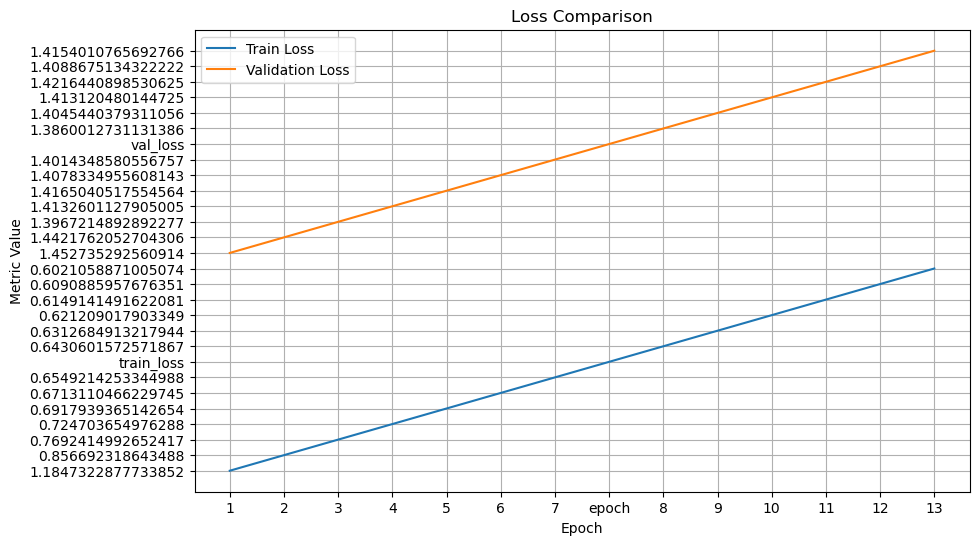

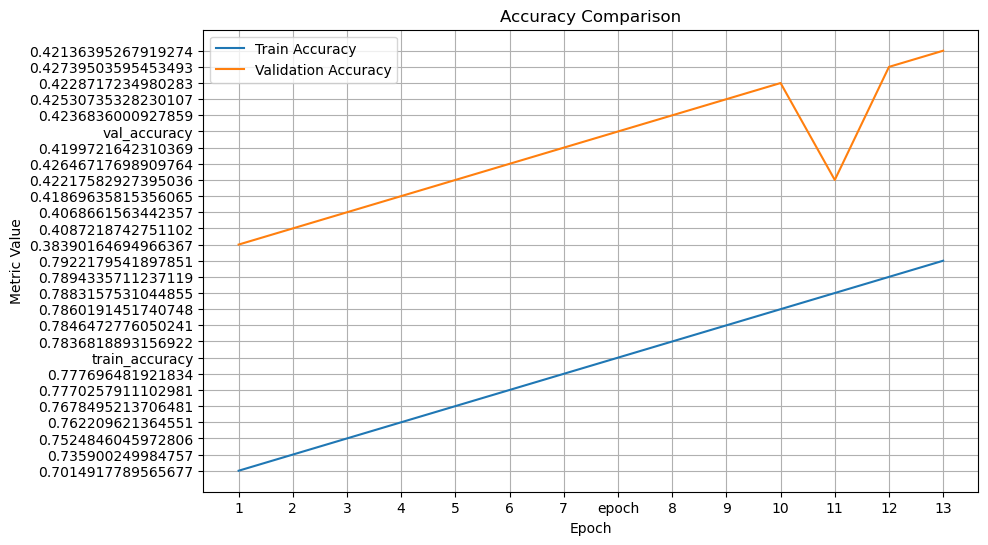

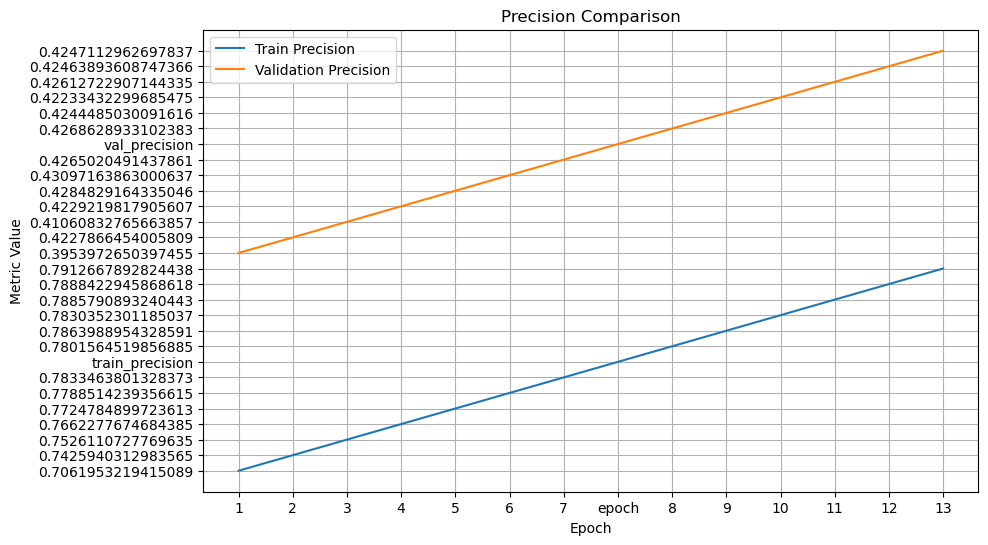

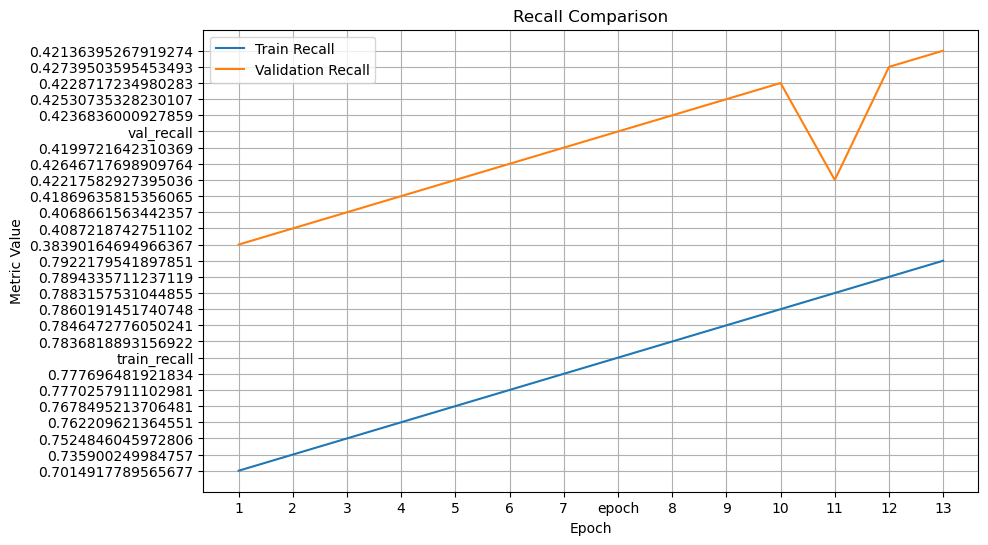

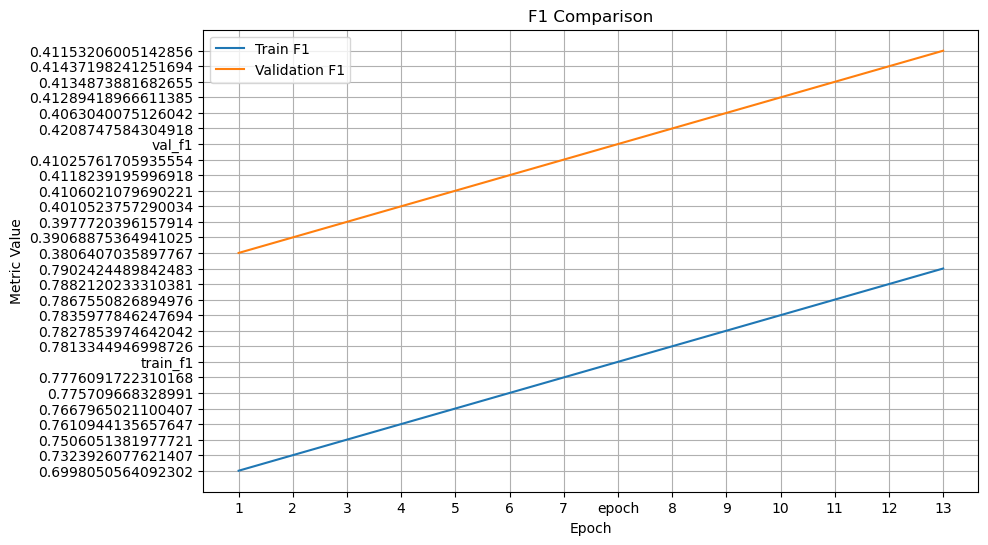

In [35]:
df = pd.read_csv(r'C:\Users\biagi\PycharmProjects\gruppo17\Esperimento 4 Multiclasse\ResNet50\training_metrics.csv')

# Estrai le metriche di addestramento e validazione
train_metrics = ['train_loss', 'train_accuracy', 'train_precision', 'train_recall', 'train_f1']
val_metrics = ['val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_f1']

# Crea un grafico separato per ogni coppia di metriche
for train_metric, val_metric in zip(train_metrics, val_metrics):
    plt.figure(figsize=(10, 6))
    plt.plot(df['epoch'], df[train_metric], label='Train ' + train_metric.split('_')[1].capitalize())
    plt.plot(df['epoch'], df[val_metric], label='Validation ' + val_metric.split('_')[1].capitalize())
    plt.xlabel('Epoch')
    plt.ylabel('Metric Value')
    plt.title(train_metric.split('_')[1].capitalize() + ' Comparison')
    plt.legend()
    plt.grid(True)
    plt.show()

Testing

In [36]:
def load_model(model_path, num_classes, device):
    num_classes = len(train_dataset.classes)
    model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    return model

model_path = r'C:\Users\biagi\PycharmProjects\gruppo17\Esperimento 4 Multiclasse\ResNet50\ResNet50_model_multiclass_final.pth'
test_dataset_path = r'C:\Users\biagi\PycharmProjects\gruppo17\Testing_Target'
checkpoint_dir = r'C:\Users\biagi\PycharmProjects\gruppo17\Esperimento 4 Multiclasse\ResNet50'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

test_dataset = CustomDataset(test_dataset_path, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4, pin_memory=True)

num_classes = len(test_dataset.classes)
model = load_model(model_path, num_classes, device)
model.eval()

criterion = nn.CrossEntropyLoss()
running_test_loss = 0.0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        outputs = model(inputs)
        test_loss = criterion(outputs, labels)
        running_test_loss += test_loss.item()

test_loss = running_test_loss / len(test_loader)
test_accuracy, test_precision, test_recall, test_f1 = calculate_metrics(test_loader, model, device)

# Creazione del file CSV nella directory dei checkpoint
csv_output_path = os.path.join(checkpoint_dir, 'test_results.csv')
with open(csv_output_path, 'w', newline='') as csvfile:
    fieldnames = ['test_loss', 'test_accuracy', 'test_precision', 'test_recall', 'test_f1']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    writer.writerow({
        'test_loss': test_loss,
        'test_accuracy': test_accuracy,
        'test_precision': test_precision,
        'test_recall': test_recall,
        'test_f1': test_f1
    })

print(f"Risultati del testing salvati in: {csv_output_path}")

Calcolo metriche: 100%|██████████| 68/68 [00:35<00:00,  1.94it/s]

Risultati del testing salvati in: C:\Users\biagi\PycharmProjects\gruppo17\Esperimento 4 Multiclasse\ResNet50\test_results.csv


Creazione Grafici

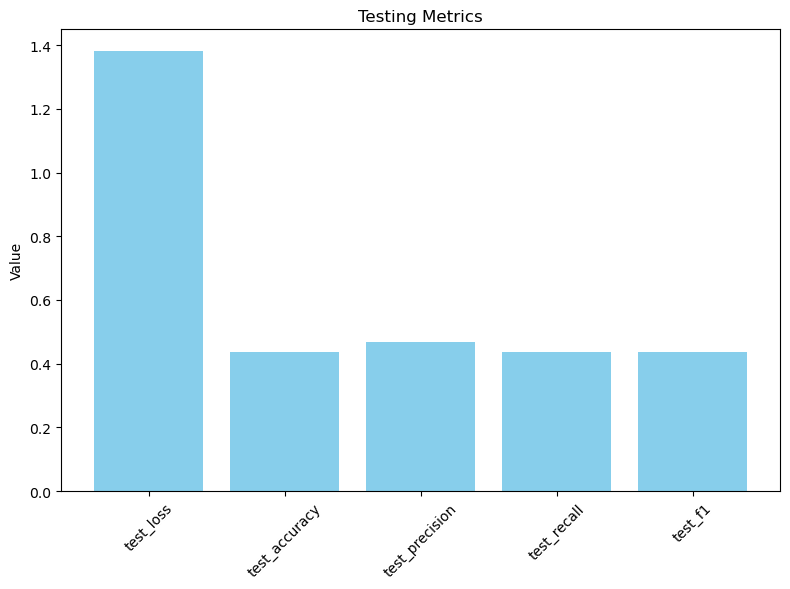

In [37]:
def plot_results(csv_file):
    results = {}
    with open(csv_file, 'r') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            for key, value in row.items():
                results[key] = float(value)

    # Plotting
    fig, ax = plt.subplots(figsize=(8, 6))

    # Bar plot
    ax.bar(results.keys(), results.values(), color='skyblue')

    ax.set_ylabel('Value')
    ax.set_title('Testing Metrics')
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.tight_layout()
    plt.show()

# Esempio di utilizzo
csv_file = r'C:\Users\biagi\PycharmProjects\gruppo17\Esperimento 4 Multiclasse\ResNet50\test_results.csv'
plot_results(csv_file)